### Task 2: Predictors of Human Harm - Aggregation Job

**Student:** Yu (Alan) Luo  
**Date:** November 22, 2025

Which states and counties experience the highest number of injuries and deaths from storm events, and what types of events are most harmful?

EDA Goals:
- Aggregate INJURIES_DIRECT, INJURIES_INDIRECT, DEATHS_DIRECT, DEATHS_INDIRECT by STATE and CZ_NAME.
- Analyze injury/death rates by EVENT_TYPE and MAGNITUDE_TYPE.
- Visualize geographic disparities in human impact.

Reason for Dataset Choice:  
The human impact metrics combined with detailed location fields allow targeted focus on public health and safety outcomes of storms.

In [1]:
import sys
import csv
from pyspark import SparkContext

def parse_csv(line):
    """Parses a CSV line safely, handling quoted fields with commas."""
    try:
        # csv.reader expects an iterable, so we wrap the line in a list
        return next(csv.reader([line]))
    except:
        return []

def extract_and_clean(row):
    """Extracts relevant columns and converts metrics to integers."""
    # Return None if row is empty or malformed
    if not row or len(row) < 29: 
        return None
        
    # Indices based on your file structure:
    # STATE=8, EVENT_TYPE=12, CZ_NAME=15
    # INJURIES_DIRECT=20, INJURIES_INDIRECT=21
    # DEATHS_DIRECT=22, DEATHS_INDIRECT=23
    # MAGNITUDE_TYPE=28
    
    try:
        state = row[8]
        event_type = row[12]
        cz_name = row[15]
        mag_type = row[28] if row[28] else "Unknown" # Handle empty magnitude
        
        # Helper to safely convert to int
        def to_int(val):
            return int(float(val)) if val and val.strip() else 0

        injuries = to_int(row[20]) + to_int(row[21])
        deaths = to_int(row[22]) + to_int(row[23])
        
        return (state, cz_name, event_type, mag_type, injuries, deaths)
    except:
        return None

# Initialize Spark Context
sc = SparkContext.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/22 20:46:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/22 20:46:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


25/11/22 20:46:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
# 1. Load Data
raw_rdd = sc.textFile("/Users/luoyu/Downloads/storm_g2020.csv")

# 2. Remove Header
header = raw_rdd.first()
data_rdd = raw_rdd.filter(lambda x: x != header)

# 3. Parse and Clean
# map: parses CSV -> filter: removes bad rows -> map: extracts columns
cleaned_rdd = data_rdd.map(parse_csv) \
                      .map(extract_and_clean) \
                      .filter(lambda x: x is not None)

# Cache heavily used RDD
cleaned_rdd.cache()

print(f"Cleaned Record Count: {cleaned_rdd.count()}")

Cleaned Record Count: 371544


### Q1: Which states and counties have the highest human impact?

In [6]:
# Key: (State, County) -> Value: (Injuries + Deaths)
geo_impact = cleaned_rdd.map(lambda x: ((x[0], x[1]), x[4] + x[5])) \
                        .reduceByKey(lambda a, b: a + b) \
                        .sortBy(lambda x: x[1], ascending=False)

print("Top 10 Counties by Human Impact:")
for loc, count in geo_impact.take(10):
    print(f"{loc[0]} - {loc[1]}: {count}")

Top 10 Counties by Human Impact:


TEXAS - DALLAS: 1427
ARIZONA - CENTRAL PHOENIX: 1027
MISSOURI - DOUGLAS: 352
TEXAS - DENTON: 315
OKLAHOMA - TULSA: 309
NEVADA - LAS VEGAS VALLEY: 271
KENTUCKY - GRAVES: 239
KENTUCKY - HOPKINS: 234
TENNESSEE - DAVIDSON: 226
ARIZONA - TUCSON METRO AREA: 225


### Q2: Impact by Event Type and Magnitude?

In [5]:
# Key: (Event Type, Magnitude Type) -> Value: (Injuries, Deaths)
type_impact = cleaned_rdd.map(lambda x: ((x[2], x[3]), (x[4], x[5]))) \
                         .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                         .sortBy(lambda x: x[1][0] + x[1][1], ascending=False)

print("\nTop 10 Event/Magnitude Types by Impact:")
for key, stats in type_impact.take(10):
    print(f"Event: {key[0]} (Mag: {key[1]}) -> Injuries: {stats[0]}, Deaths: {stats[1]}")


Top 10 Event/Magnitude Types by Impact:


Event: Tornado (Mag: Unknown) -> Injuries: 3760, Deaths: 386
Event: Excessive Heat (Mag: Unknown) -> Injuries: 1979, Deaths: 1582
Event: Heat (Mag: Unknown) -> Injuries: 574, Deaths: 1072
Event: Thunderstorm Wind (Mag: EG) -> Injuries: 962, Deaths: 198
Event: Winter Weather (Mag: Unknown) -> Injuries: 742, Deaths: 189
Event: Wildfire (Mag: Unknown) -> Injuries: 489, Deaths: 253
Event: Rip Current (Mag: Unknown) -> Injuries: 197, Deaths: 393
Event: Flash Flood (Mag: Unknown) -> Injuries: 122, Deaths: 427
Event: Lightning (Mag: Unknown) -> Injuries: 316, Deaths: 86
Event: Winter Storm (Mag: Unknown) -> Injuries: 295, Deaths: 98


Step 1: Aggregate Data for Visualization

In [7]:
import pandas as pd

# --- Chart 1 Data: Top States ---
# Map to (State, Injuries+Deaths), Reduce by key, Sort Descending, Take top 10
top_states_data = cleaned_rdd.map(lambda x: (x[0], x[4] + x[5])) \
                             .reduceByKey(lambda a, b: a + b) \
                             .sortBy(lambda x: x[1], ascending=False) \
                             .take(10) # Brings only top 10 rows to local memory

# Convert to Pandas DataFrame
df_states = pd.DataFrame(top_states_data, columns=["State", "Total_Impact"])

# --- Chart 2 Data: Top Event Types ---
# Map to (Event_Type, Injuries+Deaths), Reduce by key, Sort Descending, Take top 10
top_events_data = cleaned_rdd.map(lambda x: (x[2], x[4] + x[5])) \
                             .reduceByKey(lambda a, b: a + b) \
                             .sortBy(lambda x: x[1], ascending=False) \
                             .take(10)

# Convert to Pandas DataFrame
df_events = pd.DataFrame(top_events_data, columns=["Event_Type", "Total_Impact"])

print("Data ready for plotting.")

Data ready for plotting.


Step 2: Generate the Charts

In [9]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 9.8 MB/s  0:00:00m eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.7 MB/s  0:00:006m0:00:0100:01
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


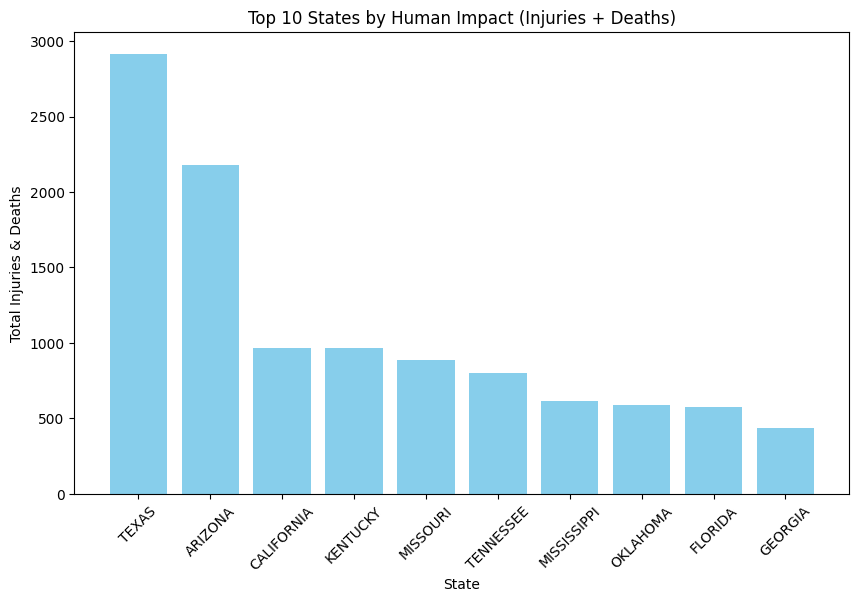

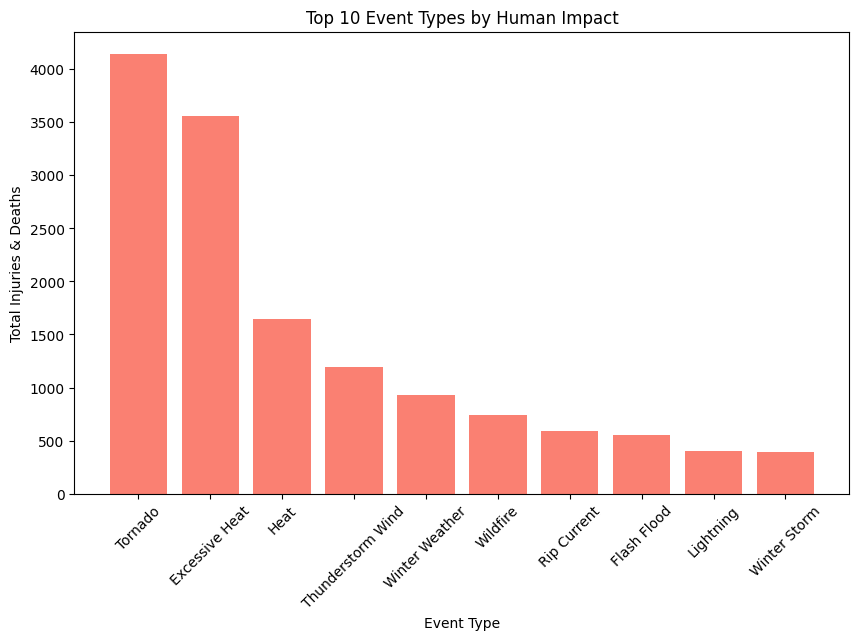

In [10]:
import matplotlib.pyplot as plt

# --- Plot 1: Top States ---
plt.figure(figsize=(10, 6))
plt.bar(df_states["State"], df_states["Total_Impact"], color='skyblue')
plt.title("Top 10 States by Human Impact (Injuries + Deaths)")
plt.xlabel("State")
plt.ylabel("Total Injuries & Deaths")
plt.xticks(rotation=45) # Rotate labels for readability
plt.show()

# --- Plot 2: Top Event Types ---
plt.figure(figsize=(10, 6))
plt.bar(df_events["Event_Type"], df_events["Total_Impact"], color='salmon')
plt.title("Top 10 Event Types by Human Impact")
plt.xlabel("Event Type")
plt.ylabel("Total Injuries & Deaths")
plt.xticks(rotation=45)
plt.show()